In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os

## SRTT

/tmp/ipykernel_8335/2408588446.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cumulative_df[f'{service}_cumulative'] = df[columns].fillna(0).sum(axis=1)
/tmp/ipykernel_8335/2408588446.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cumulative_df[f'{service}_cumulative'] = df[columns].fillna(0).sum(axis=1)
/tmp/ipykernel_8335/2408588446.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at

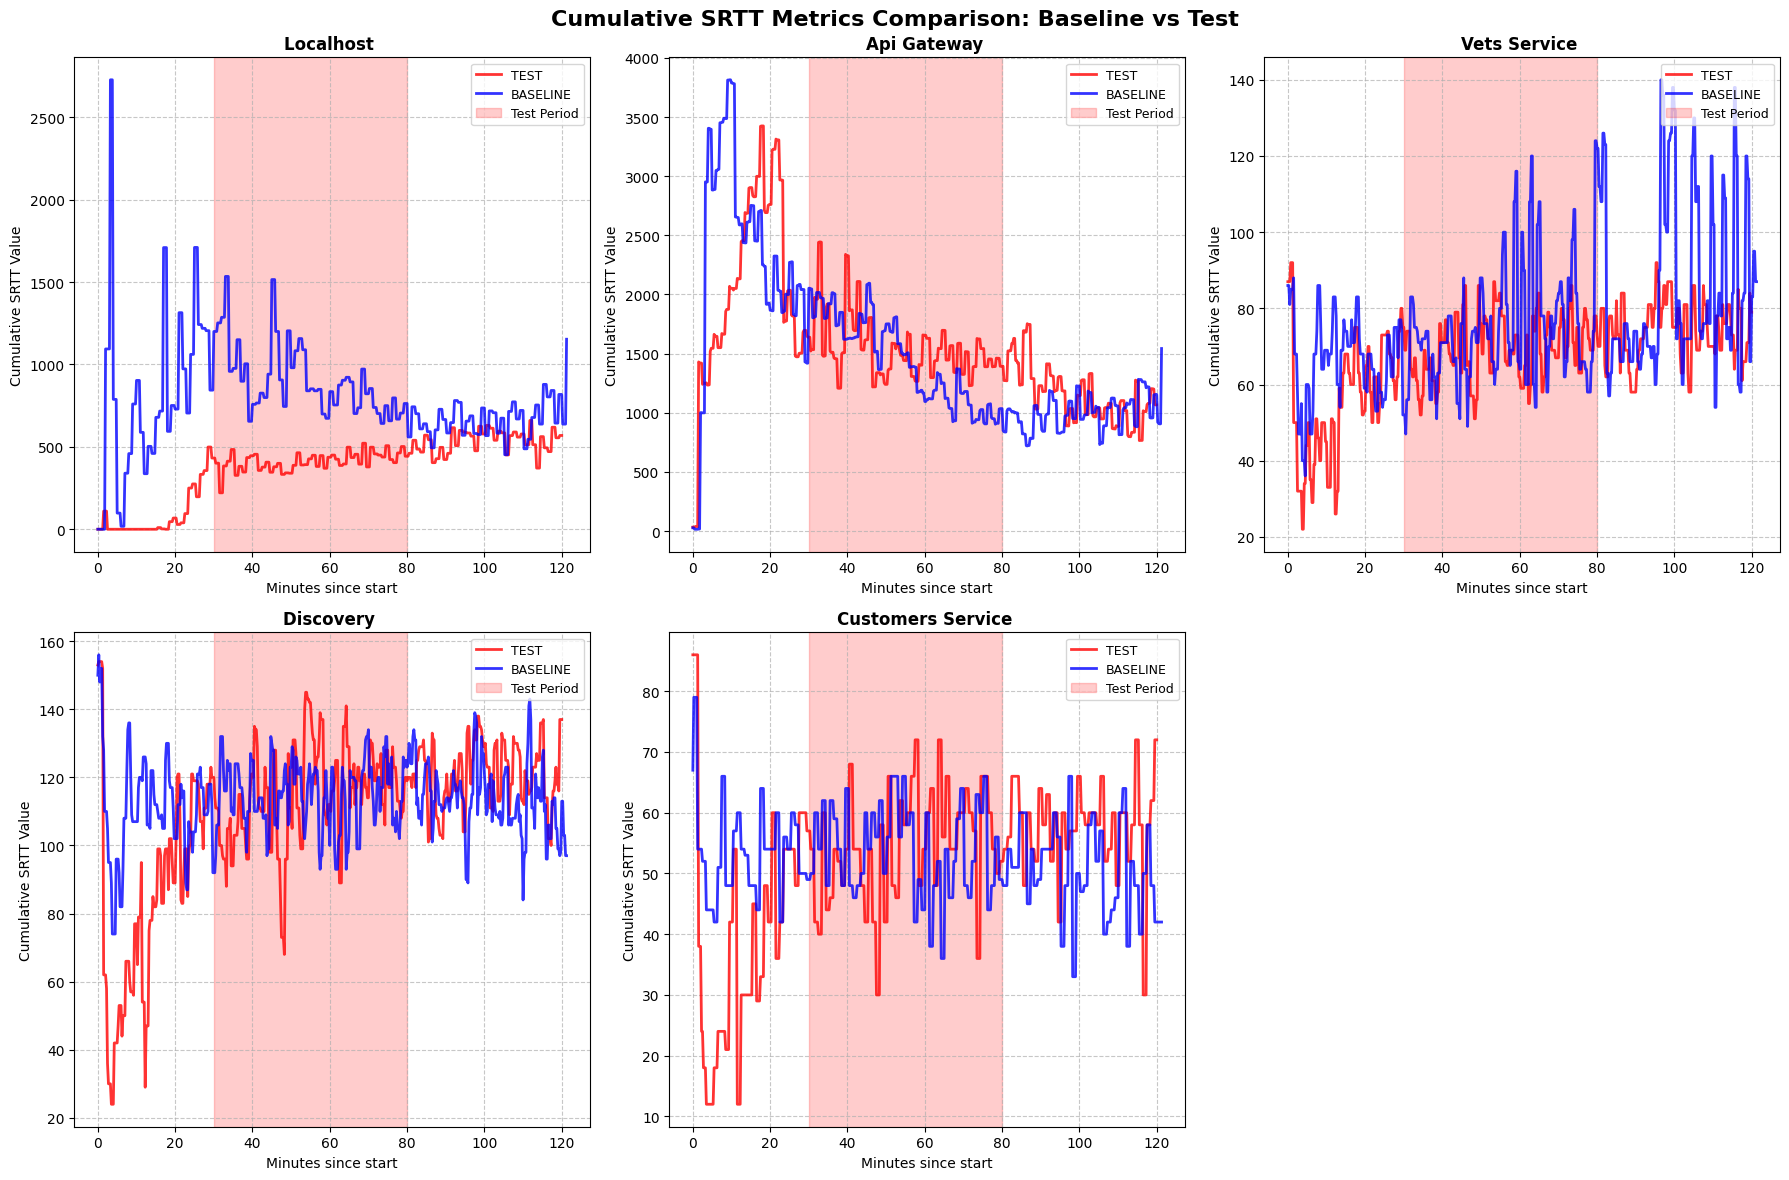

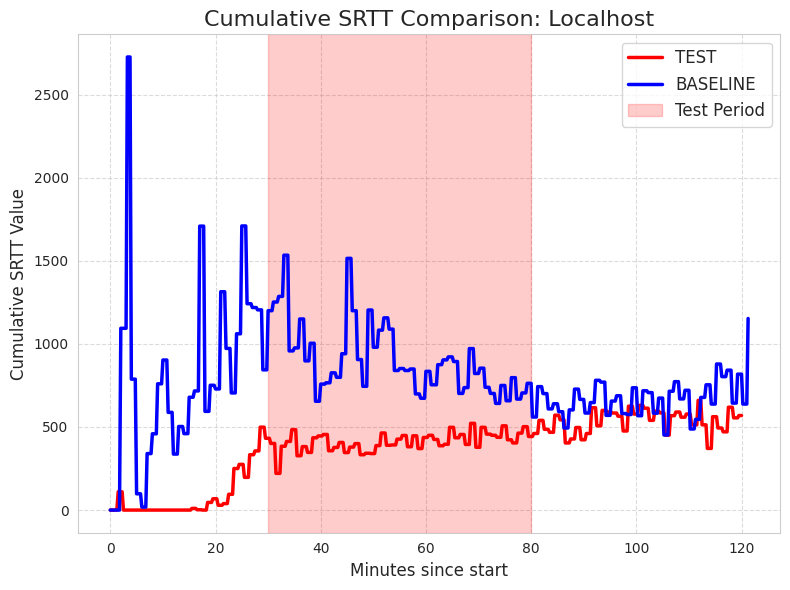

/tmp/ipykernel_8335/2408588446.py:78: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test_cumulative['total_system_srtt'] = df_test_cumulative[cumulative_metrics].sum(axis=1)
/tmp/ipykernel_8335/2408588446.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_baseline_cumulative['total_system_srtt'] = df_baseline_cumulative[cumulative_metrics].sum(axis=1)


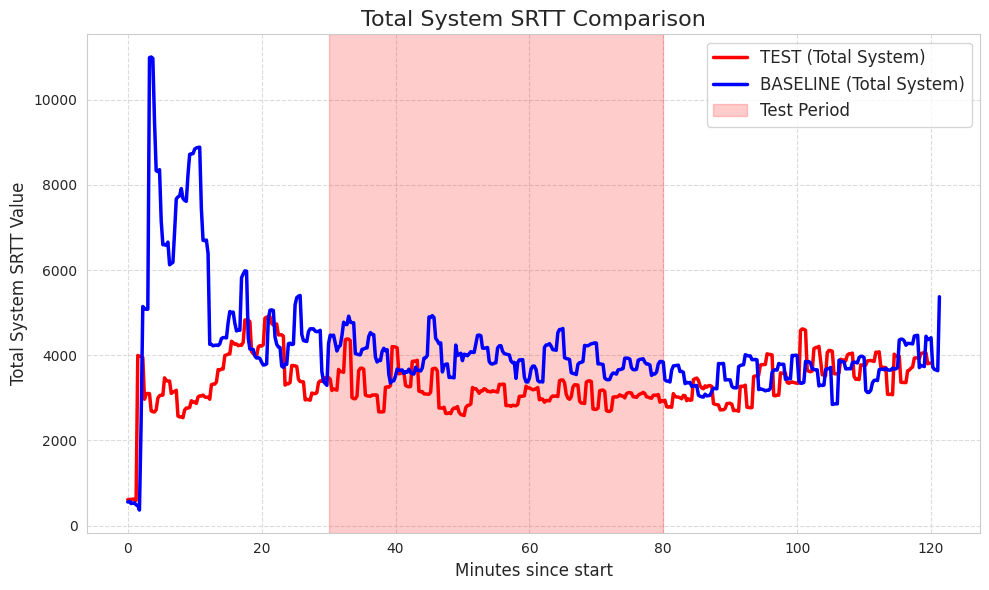

In [2]:
df_test = pd.read_csv("srtt.csv")
df_baseline = pd.read_csv("../../baseline/tcp related/srtt.csv")

df_test["source"] = "TEST"
df_baseline["source"] = "BASELINE"

df_test["Time"] = pd.to_datetime(df_test["Time"])
df_baseline["Time"] = pd.to_datetime(df_baseline["Time"])

df_test["Minutes"] = (df_test["Time"] - df_test["Time"].min()).dt.total_seconds() / 60
df_baseline["Minutes"] = (df_baseline["Time"] - df_baseline["Time"].min()).dt.total_seconds() / 60

delay = 30
duration = 50

def create_cumulative_metrics(df):
    metric_columns = [col for col in df.columns if col not in ['Time', 'source', 'Minutes']]
    service_groups = {}
    for col in metric_columns:
        if '_client_' in col or '_server_' in col:
            service_name = col.split('_client_')[0] if '_client_' in col else col.split('_server_')[0]
        else:
            service_name = col
        if service_name not in service_groups:
            service_groups[service_name] = []
        service_groups[service_name].append(col)
    cumulative_df = df[['Time', 'Minutes', 'source']].copy()
    for service, columns in service_groups.items():
        cumulative_df[f'{service}_cumulative'] = df[columns].fillna(0).sum(axis=1)
    return cumulative_df

df_test_cumulative = create_cumulative_metrics(df_test)
df_baseline_cumulative = create_cumulative_metrics(df_baseline)

cumulative_metrics = [col for col in df_test_cumulative.columns if col.endswith('_cumulative')]
key_cumulative_metrics = cumulative_metrics[:5]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Cumulative SRTT Metrics Comparison: Baseline vs Test', fontsize=16, fontweight='bold')
axes_flat = axes.flatten()

for i, metric in enumerate(key_cumulative_metrics):
    if i < len(axes_flat):
        ax = axes_flat[i]
        ax.plot(df_test_cumulative["Minutes"], df_test_cumulative[metric], label="TEST", color='red', linewidth=2, alpha=0.8)
        ax.plot(df_baseline_cumulative["Minutes"], df_baseline_cumulative[metric], label="BASELINE", color='blue', linewidth=2, alpha=0.8)
        ax.axvspan(delay, delay + duration, color='red', alpha=0.2, label="Test Period")
        service_name = metric.replace('_cumulative', '').replace('_', ' ').title()
        ax.set_title(f'{service_name} ', fontsize=12, fontweight='bold')
        ax.set_xlabel("Minutes since start", fontsize=10)
        ax.set_ylabel("Cumulative SRTT Value", fontsize=10)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend(loc='upper right', fontsize=9)

for i in range(len(key_cumulative_metrics), len(axes_flat)):
    fig.delaxes(axes_flat[i])

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")

if key_cumulative_metrics:
    metric_focus = key_cumulative_metrics[0]
    plt.plot(df_test_cumulative["Minutes"], df_test_cumulative[metric_focus], label="TEST", color='red', linewidth=2.5)
    plt.plot(df_baseline_cumulative["Minutes"], df_baseline_cumulative[metric_focus], label="BASELINE", color='blue', linewidth=2.5)
    plt.axvspan(delay, delay + duration, color='red', alpha=0.2, label="Test Period")
    service_name = metric_focus.replace('_cumulative', '').replace('_', ' ').title()
    plt.title(f"Cumulative SRTT Comparison: {service_name}", fontsize=16)
    plt.xlabel("Minutes since start", fontsize=12)
    plt.ylabel("Cumulative SRTT Value", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='upper right', fontsize=12)
    plt.tight_layout()
    plt.show()

df_test_cumulative['total_system_srtt'] = df_test_cumulative[cumulative_metrics].sum(axis=1)
df_baseline_cumulative['total_system_srtt'] = df_baseline_cumulative[cumulative_metrics].sum(axis=1)

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
plt.plot(df_test_cumulative["Minutes"], df_test_cumulative['total_system_srtt'], label="TEST (Total System)", color='red', linewidth=2.5)
plt.plot(df_baseline_cumulative["Minutes"], df_baseline_cumulative['total_system_srtt'], label="BASELINE (Total System)", color='blue', linewidth=2.5)
plt.axvspan(delay, delay + duration, color='red', alpha=0.2, label="Test Period")
plt.title("Total System SRTT Comparison", fontsize=16)
plt.xlabel("Minutes since start", fontsize=12)
plt.ylabel("Total System SRTT Value", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper right', fontsize=12)
plt.tight_layout()
plt.show()


## retransmitted packets

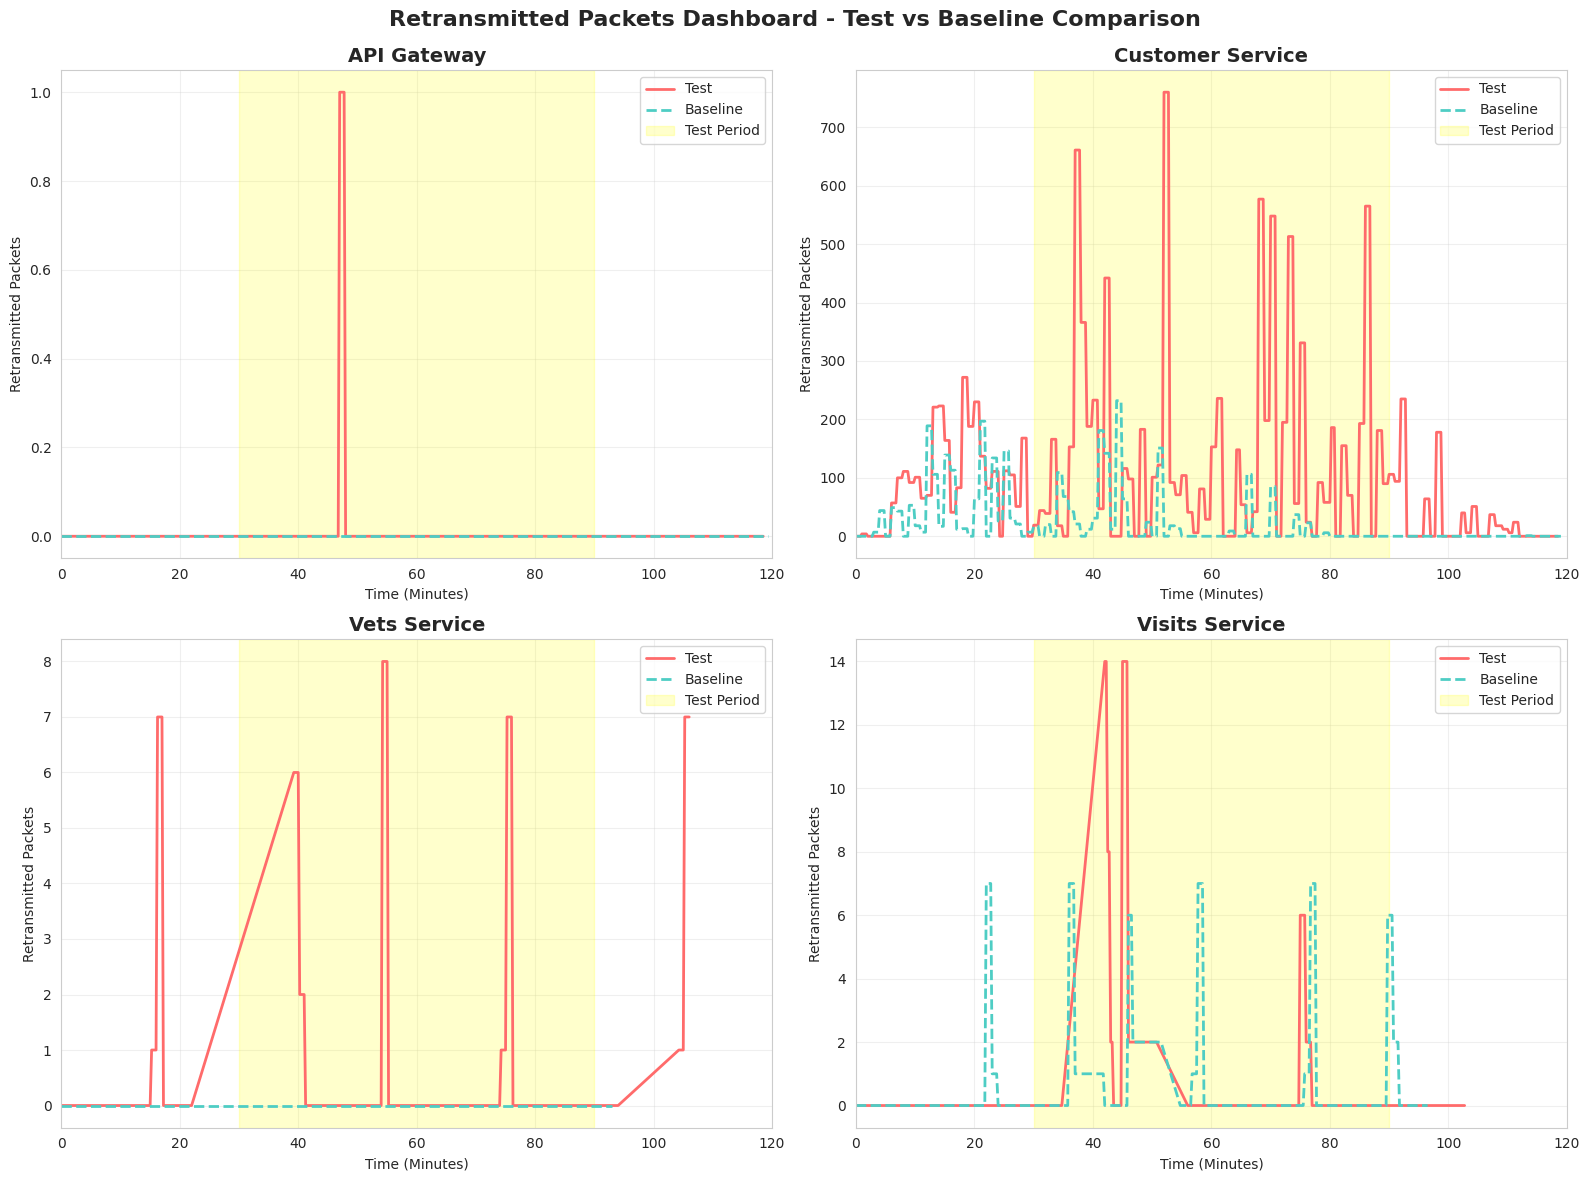

In [3]:
df_api_gateway = pd.read_csv('./retrans_packets/api_gateway.csv')
df_customers_service = pd.read_csv('./retrans_packets/customers_service.csv')
df_visits_service = pd.read_csv('./retrans_packets/visits_service.csv')
df_vets_service = pd.read_csv('./retrans_packets/vets_service.csv')

df_api_gateway_baseline = pd.read_csv("../../baseline/tcp related/retrans_packets/api_gateway.csv")
df_customers_service_baseline = pd.read_csv("../../baseline/tcp related/retrans_packets/customers_service.csv")
df_vets_service_baseline = pd.read_csv("../../baseline/tcp related/retrans_packets/vets_service.csv")
df_visits_service_baseline = pd.read_csv("../../baseline/tcp related/retrans_packets/visits_service.csv")

datasets = [
    df_api_gateway, df_customers_service, df_vets_service, df_visits_service,
    df_api_gateway_baseline, df_customers_service_baseline, df_vets_service_baseline, df_visits_service_baseline
]

for df in datasets:
    df['Time'] = pd.to_datetime(df['Time'])

df_api_gateway['Minutes'] = (df_api_gateway['Time'] - df_api_gateway['Time'].min()).dt.total_seconds() / 60
df_customers_service['Minutes'] = (df_customers_service['Time'] - df_customers_service['Time'].min()).dt.total_seconds() / 60
df_vets_service['Minutes'] = (df_vets_service['Time'] - df_vets_service['Time'].min()).dt.total_seconds() / 60
df_visits_service['Minutes'] = (df_visits_service['Time'] - df_visits_service['Time'].min()).dt.total_seconds() / 60

df_api_gateway_baseline['Minutes'] = (df_api_gateway_baseline['Time'] - df_api_gateway_baseline['Time'].min()).dt.total_seconds() / 60
df_customers_service_baseline['Minutes'] = (df_customers_service_baseline['Time'] - df_customers_service_baseline['Time'].min()).dt.total_seconds() / 60
df_vets_service_baseline['Minutes'] = (df_vets_service_baseline['Time'] - df_vets_service_baseline['Time'].min()).dt.total_seconds() / 60
df_visits_service_baseline['Minutes'] = (df_visits_service_baseline['Time'] - df_visits_service_baseline['Time'].min()).dt.total_seconds() / 60

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Retransmitted Packets Dashboard - Test vs Baseline Comparison', fontsize=16, fontweight='bold')

test_color = '#FF6B6B'      # Red for test
baseline_color = '#4ECDC4'   # Teal for baseline

ax1 = axes[0, 0]
ax1.plot(df_api_gateway['Minutes'], df_api_gateway['api_gateway'], 
         label='Test', linewidth=2, color=test_color)
ax1.plot(df_api_gateway_baseline['Minutes'], df_api_gateway_baseline['api_gateway'], 
         label='Baseline', linewidth=2, color=baseline_color, linestyle='--')
ax1.set_title('API Gateway', fontsize=14, fontweight='bold')
ax1.set_xlabel('Time (Minutes)')
ax1.set_ylabel('Retransmitted Packets')
ax1.axvspan(30, 90, color='yellow', alpha=0.2, label="Test Period")
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 120)

ax2 = axes[0, 1]
ax2.plot(df_customers_service['Minutes'], df_customers_service['customers_service'], 
         label='Test', linewidth=2, color=test_color)
ax2.plot(df_customers_service_baseline['Minutes'], df_customers_service_baseline['customers_service'], 
         label='Baseline', linewidth=2, color=baseline_color, linestyle='--')
ax2.set_title('Customer Service', fontsize=14, fontweight='bold')
ax2.set_xlabel('Time (Minutes)')
ax2.axvspan(30, 90, color='yellow', alpha=0.2, label="Test Period")
ax2.set_ylabel('Retransmitted Packets')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 120)

ax3 = axes[1, 0]
ax3.plot(df_vets_service['Minutes'], df_vets_service['vets_service'], 
         label='Test', linewidth=2, color=test_color)
ax3.plot(df_vets_service_baseline['Minutes'], df_vets_service_baseline['vets_service'], 
         label='Baseline', linewidth=2, color=baseline_color, linestyle='--')
ax3.set_title('Vets Service', fontsize=14, fontweight='bold')
ax3.set_xlabel('Time (Minutes)')
ax3.set_ylabel('Retransmitted Packets')
ax3.axvspan(30, 90, color='yellow', alpha=0.2, label="Test Period")
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_xlim(0, 120)

ax4 = axes[1, 1]
ax4.plot(df_visits_service['Minutes'], df_visits_service['visits_service'], 
         label='Test', linewidth=2, color=test_color)
ax4.plot(df_visits_service_baseline['Minutes'], df_visits_service_baseline['visits_service'], 
         label='Baseline', linewidth=2, color=baseline_color, linestyle='--')
ax4.set_title('Visits Service', fontsize=14, fontweight='bold')
ax4.set_xlabel('Time (Minutes)')
ax4.set_ylabel('Retransmitted Packets')
ax4.axvspan(30, 90, color='yellow', alpha=0.2, label="Test Period")
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.set_xlim(0, 120)
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()